# Implementing the Convolution Layer


In this course, we will implement a 1D convolution layer. In the convolution layers course, we only discussed 2D convolution, as it is the most commonly used. However, to fully understand the code and the ingenuity of convolution layers, it is essential to start with 1D convolution.


## How 1D Convolution Works


1D convolution is quite similar to 2D convolution, but in one dimension. By applying a 1D convolution layer, we quickly understand why a convolution layer is essentially a *for* loop.
![conv1d](./images/conv1d.png)
Figure from the [forum](https://ai.stackexchange.com/questions/28767/what-does-channel-mean-in-the-case-of-an-1d-convolution).
The standard parameters of 2D convolution also apply:
- *Padding* adds values to the edges of the 1D vector (beginning and end)
- *Stride* defines the step
- *Kernel_size* defines the filter size
- *In_channels* and *out_channels* correspond to the number of input and output channels
- etc.


## Implementation


We will now implement the 1D convolution layer.
**Note**: In PyTorch, convolution layers are not implemented in Python but in C++ for faster computation.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In a convolution layer, we have a filter dimension *kernel_size* and a number of filters *out_channels*. The idea is to loop through the entire vector and calculate the output values by applying each filter to every possible position of the input vector. At each position, we apply a fully connected layer that takes as input the elements contained in the filter of size $(KernelSize \times InChannels)$ and returns $OutChannels$ elements. It's as if we applied a *for* loop to each position in the input sequence.
**Note**: In the explanatory figure, there is only one channel dimension, but in reality, there are usually several.


In [14]:
in_channels = 3
out_channels = 16
kernel_size = 3
kernel=nn.Linear(in_channels*kernel_size, out_channels)

Now, we need to apply this convolution layer to all elements of the sequence with a *stride* step. We can also add *padding* if we want the input sequence to have the same size as the output sequence.


In [21]:
# Imaginons une séquence de 100 éléments, avec 3 canaux et un batch de 8
dummy_input = torch.randn(8, in_channels, 100)
print("Dimension de l'entrée: ",dummy_input.shape)
stride=1
padding=1
outs=[]

# On pad les deux côtés de l'entrée pour éviter les problèmes de dimensions
dummy_input=F.pad(dummy_input, (padding, padding))

for i in range(kernel_size,dummy_input.shape[2]+1,stride):
  chunk=dummy_input[:,:,i-kernel_size:i]
  # On redimensionne pour la couche fully connected
  chunk=chunk.reshape(dummy_input.shape[0],-1)
  # On applique la couche fully connected
  out=kernel(chunk)
  # On ajoute à la liste des sorties
  outs.append(out)
# On convertit la liste en un tenseur
outs=torch.stack(outs, dim=2)
print("Dimension de la sortie: ",outs.shape)

Dimension de l'entrée:  torch.Size([8, 3, 100])
Dimension de la sortie:  torch.Size([8, 16, 100])


As with 2D convolutions, we can choose to reduce the size of the sequence (or *feature maps* if we are talking about a 2D conv). To do this, we can use a *stride* greater than 1 or a *pooling* layer.
In practice, using *stride* is often preferred, but we will implement *max pooling* to fully understand how it works.


In [27]:
pooling=2
outs2=[]
for i in range(pooling,outs.shape[2]+1,pooling):
  # On prend les éléments entre i-pooling et i
  chunk=outs[:,:,i-pooling:i]
  # On prend le max sur la dimension 2, pour le average pooling on aurait utilisé torch.mean
  out2=torch.max(chunk, dim=2)[0]
  outs2.append(out2)
# On convertit la liste en un tenseur 
outs2=torch.stack(outs2, dim=2)
print("Dimension de la sortie après pooling: ",outs2.shape)

Dimension de la sortie après pooling:  torch.Size([8, 16, 50])


Now that we understand how 1D convolution and *max pooling* work, we will create classes to facilitate their use.


In [29]:
class Conv1D(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
    super(Conv1D, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.kernel_width = kernel_size
    self.kernel = nn.Linear(kernel_size * in_channels, out_channels)
    self.padding=padding

  def forward(self, x):
    x=F.pad(x, (self.padding, self.padding))
    # Boucle en une seule ligne pour un code plus concis
    l = [self.kernel(x[:, :, i - self.kernel_width: i].reshape(x.shape[0], self.in_channels * self.kernel_width)) for i in range(self.kernel_width, x.shape[2]+1, self.stride)]
    return torch.stack(l, dim=2)


class MaxPool1D(nn.Module):
  def __init__(self, pooling):
    super(MaxPool1D, self).__init__()
    self.pooling = pooling
    
  def forward(self, x):
    # Boucle en une seule ligne pour un code plus concis
    l = [torch.max(x[:, :, i - self.pooling: i], dim=2)[0] for i in range(self.pooling, x.shape[2]+1, self.pooling)]
    return torch.stack(l, dim=2)

## Practical Case: MNIST


Now that we have implemented our convolution and *pooling* layers, we will test them on MNIST. On MNIST, we process images, so it is more logical to use 2D convolutions in practice (see next course). Here, we will simply verify that our convolution implementation works.


In [38]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Dataset


In [39]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

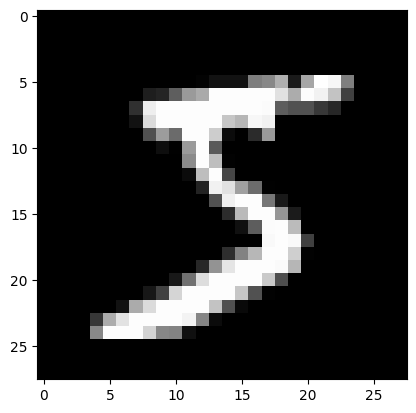

Le chiffre sur l'image est un 0


In [40]:
plt.imshow(dataset[0][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[1][1]))

In [41]:
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We can now create our model. Note that we use a *stride* of 2 and no *max pooling* to save time on processing.


In [49]:
class cnn1d(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=Conv1D(1,8,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 8 filtres
    self.conv2=Conv1D(8,16,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 16 filtres
    self.conv3=Conv1D(16,32,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 32 filtres
    self.fc=nn.Linear(3136,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,x.shape[1]*x.shape[2]) # Pour convertir la feature map de taille CxL en vecteur 1D (avec une dimension batch)
    output=self.fc(x)
    return output
dummy_input=torch.randn(8,1,784)
model=cnn1d()
output=model(dummy_input)
print(output.shape)

print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

torch.Size([8, 10])
Nombre de paramètres 33370


The model has almost 10 times fewer parameters than our fully connected model from the previous course!


In [50]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [51]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    images=images.view(images.shape[0],1,784)
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      images=images.view(images.shape[0],1,784)
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.4011246860027313
step 0 val loss 0.2103319615125656
step 1 train loss 0.17427290976047516
step 1 val loss 0.1769915670156479
step 2 train loss 0.14464063942432404
step 2 val loss 0.14992524683475494
step 3 train loss 0.12802869081497192
step 3 val loss 0.13225941359996796
step 4 train loss 0.11609579622745514
step 4 val loss 0.12663421034812927


In [53]:
correct = 0
total = 0
for images,labels in test_loader:
  images=images.view(images.shape[0],1,784) 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  96.35


We achieve a very good accuracy, although slightly lower than that obtained with the fully connected network from the previous course.
**Note**: Training was quite slow because our implementation is not very efficient. The PyTorch implementation in C++ is much more performant.
**Note 2**: We used 1D convolutions to process images, which is not optimal. The ideal is to use 2D convolutions.


## Bonus: Conv2D


We can implement 2D convolution by following the same principle, but in two dimensions.


In [15]:
in_channels = 3
out_channels = 16
kernel_size = 3
# On a un kernel de taille 3x3 car on est en 2D
kernel=nn.Linear(in_channels*kernel_size**2, out_channels)

In [16]:
# Pour une image de taille 10x10 avec 3 canaux et un batch de 8
dummy_input = torch.randn(8, in_channels, 10,10)
b, c, h, w = dummy_input.shape
print("Dimension de l'entrée: ",dummy_input.shape)
stride=1
padding=1
outs=[]

# Le padding change pour une image 2D, on doit pad en hauteur et en largeur
dummy_input=F.pad(dummy_input, (padding, padding,padding,padding))
print("Dimension de l'entrée après padding: ",dummy_input.shape)

# On boucle sur les dimensions de l'image : W x H 
for i in range(kernel_size,dummy_input.shape[2]+1,stride):
  for j in range(kernel_size,dummy_input.shape[3]+1,stride):
    chunk=dummy_input[:,:,i-kernel_size:i,j-kernel_size:j]
    # On redimensionne pour la couche fully connected
    chunk=chunk.reshape(dummy_input.shape[0],-1)
    # On applique la couche fully connected
    out=kernel(chunk)
    # On ajoute à la liste des sorties
    outs.append(out)
# On convertit la liste en un tenseur
outs=torch.stack(outs, dim=2)
outs=outs.reshape(b,out_channels,h, w)
print("Dimension de la sortie: ",outs.shape)

Dimension de l'entrée:  torch.Size([8, 3, 10, 10])
Dimension de l'entrée après padding:  torch.Size([8, 3, 12, 12])
Dimension de la sortie:  torch.Size([8, 16, 10, 10])


We can do this in class now, just like with conv1D.


In [34]:
class Conv2D(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
    super(Conv2D, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.kernel_width = kernel_size
    self.kernel = nn.Linear(in_channels*kernel_size**2 , out_channels)
    self.padding=padding

  def forward(self, x):
    b, c, h, w = x.shape
    x=F.pad(x, (self.padding, self.padding,self.padding,self.padding))
    # Sur une seule ligne, c'est absolument illisible, on garde la boucle
    l=[]
    for i in range(self.kernel_width, x.shape[2]+1, self.stride):
      for j in range(self.kernel_width, x.shape[3]+1, self.stride):
        chunk=self.kernel(x[:,:,i-self.kernel_width:i,j-self.kernel_width:j].reshape(x.shape[0],-1))
        l.append(chunk)
    # La version en une ligne, pour les curieux
    #l = [self.kernel(x[:, :, i - self.kernel_width: i, j - self.kernel_width: j].reshape(x.shape[0], ,-1)) for i in range(self.kernel_width, x.shape[2]+1, self.stride) for j in range(self.kernel_width, x.shape[3]+1, self.stride)]
    outs=torch.stack(l, dim=2)
    return outs.reshape(b,self.out_channels,h//self.stride, w//self.stride)

dummy_input=torch.randn(8,3,32,32)
model=Conv2D(3,16,stride=2,kernel_size=3,padding=1)
output=model(dummy_input)
print(output.shape)

torch.Size([8, 16, 16, 16])


We can now create our model.


In [50]:
class cnn2d(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=Conv2D(1,8,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 8 filtres
    self.conv2=Conv2D(8,16,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 16 filtres
    self.conv3=Conv2D(16,32,kernel_size=3,stride=1,padding=1) # Couche de convolution 1D de 32 filtres
    self.fc=nn.Linear(1568,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]) # Pour convertir la feature map de taille CxL en vecteur 1D (avec une dimension batch)
    output=self.fc(x)
    return output
dummy_input=torch.randn(8,1,28,28)
model=cnn2d()
output=model(dummy_input)
print(output.shape)

print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

torch.Size([8, 10])
Nombre de paramètres 21578


We can now train our model on MNIST and see if we get better results than with 1D convolutions.


In [51]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [52]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.36240848898887634
step 0 val loss 0.14743468165397644
step 1 train loss 0.1063414067029953
step 1 val loss 0.1019362062215805
step 2 train loss 0.07034476101398468
step 2 val loss 0.08669546991586685
step 3 train loss 0.05517915263772011
step 3 val loss 0.07208992540836334
step 4 train loss 0.04452721029520035
step 4 val loss 0.0664198026061058


In terms of *loss*, we went lower than for our model with 1D convolutions.


In [53]:
correct = 0
total = 0
for images,labels in test_loader:
  with torch.no_grad():
    preds=model(images)
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  98.23


The accuracy is very good! It's better than what we had with the [fully connected networks](../02_RéseauFullyConnected/03_TechniquesAvancées.ipynb), even though we have 10 times fewer parameters.


**Note**: Similarly, we can implement 3D convolutions that can be used for video processing (the temporal axis is added).
